In [3]:
import os 
import xarray as xr
from utils.ndvi_functions import add_time, compute_radiance
from utils.ndvi_functions import compute_ndvi
from utils.function_clns import config

path = "/media/BIFROST/N2/Riccardo/MSG/msg_data/batch_1"
chunks = {"time":200, "lat":50, "lon":50}


# def preprocess(ds):
#     ds = add_time(ds)
#     ds = compute_radiance(ds)
#     return ds 
    
# files = [os.path.join(path, file) for file in os.listdir(path) if file.endswith(".nc")]
# ds = xr.open_mfdataset(files, chunks=chunks, preprocess=preprocess, engine='netcdf4', parallel=True)
# ndvi = compute_ndvi(ds)


In [3]:
filename = "ndvi_full_image.zarr"

on_disk = xr.open_zarr(os.path.join(config["NDVI"]["ndvi_path"],filename), chunks=chunks)

/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/site-packages/xarray/core/dataset.py:275: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 200. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [19]:
from utils.ndvi_functions import add_time

def preprocess(ds):
    ds = add_time(ds)
    return ds 
    

path1 = "/media/BIFROST/N2/Riccardo/MSG/cloudmask/processed_clouds/09_30"
files = [os.path.join(path1, file) for file in os.listdir(path1) if file.endswith(".nc")][:4]
ds_cloud1 = xr.open_mfdataset(files, preprocess=preprocess)

path2 = "/media/BIFROST/N2/Riccardo/MSG/cloudmask/processed_clouds/09_00"
files = [os.path.join(path2, file) for file in os.listdir(path2) if file.endswith(".nc")][:4]
ds_cloud2 = xr.open_mfdataset(files, preprocess=preprocess, engine='netcdf4')

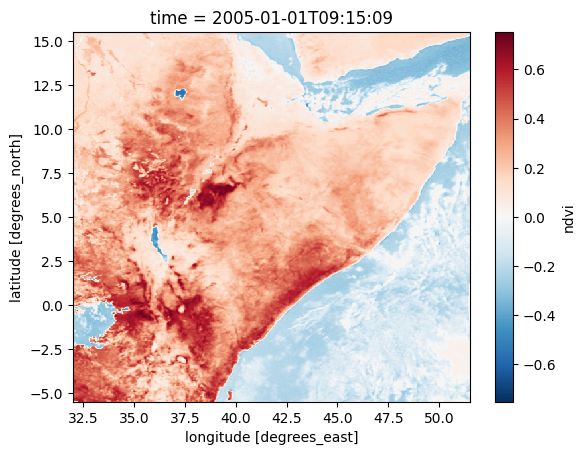

In [4]:
on_disk.isel(time=0).ndvi.plot()

In [4]:
import zarr

compressor = zarr.Blosc(cname="zstd", clevel=3, shuffle=2)
# encodings
enc = {x: {"compressor": compressor} for x in ds}

filename = "ndvi_full_image.zarr"
# encoding = {'zlib': True, "complevel":4}
# compression = {"ndvi" :encoding, "channel_1":encoding, "channel_2": encoding}
from utils.function_clns import config
from dask.diagnostics import ProgressBar

with ProgressBar():
    ndvi.to_zarr(os.path.join(config["NDVI"]["ndvi_path"], filename),
             encoding=enc)

[                                        ] | 0% Completed | 333.62 ss

IOStream.flush timed out


[########################################] | 100% Completed | 6hr 42m


In [ ]:
from vegetation.preprocessing.ndvi_clean import XarrayWS

ws = XarrayWS(on_disk.chunk({"time":-1, "lat":50, "lon":50}))
data = ws.apply_ws2doptvp("ndvi", p=0.99, lambda_max=4)

In [5]:
mean_ndvi = on_disk["ndvi"].mean(["lat","lon"])

In [ ]:
from dask.diagnostics import ProgressBar

with ProgressBar():
    mean_ndvi.plot()

In [ ]:
import os
from utils.function_clns import config, prepare, subsetting_pipeline
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

dataset = prepare(subsetting_pipeline( 
            xr.open_dataarray(os.path.join(config['NDVI']['ndvi_path'], 
            "ndvi_smoothed_w2s.nc")))).transpose("time","lon","lat")


In [1]:
from vegetation.data_collection.ee_modis import EeModis
from utils.function_clns import config


start_date = "2012-08-20"
end_date = "2023-12-31"

modis_data = EeModis(start_date, end_date, name="NDVI_06")

Total number of images: 3813

Exporting 1/3813: /media/BIFROST/N2/Riccardo/MODIS/MODIS_NDVI/2012_08_20.tif
Generating URL ...
Please wait ...
Data downloaded to /media/BIFROST/N2/Riccardo/MODIS/MODIS_NDVI/2012_08_20.tif


Exporting 2/3813: /media/BIFROST/N2/Riccardo/MODIS/MODIS_NDVI/2012_08_21.tif
Generating URL ...
Please wait ...
Data downloaded to /media/BIFROST/N2/Riccardo/MODIS/MODIS_NDVI/2012_08_21.tif


Exporting 3/3813: /media/BIFROST/N2/Riccardo/MODIS/MODIS_NDVI/2012_08_22.tif
Generating URL ...
Please wait ...
Data downloaded to /media/BIFROST/N2/Riccardo/MODIS/MODIS_NDVI/2012_08_22.tif


Exporting 4/3813: /media/BIFROST/N2/Riccardo/MODIS/MODIS_NDVI/2012_08_23.tif
Generating URL ...
Please wait ...
Data downloaded to /media/BIFROST/N2/Riccardo/MODIS/MODIS_NDVI/2012_08_23.tif


Exporting 5/3813: /media/BIFROST/N2/Riccardo/MODIS/MODIS_NDVI/2012_08_24.tif
Generating URL ...
Please wait ...
Data downloaded to /media/BIFROST/N2/Riccardo/MODIS/MODIS_NDVI/2012_08_24.tif


Exporting 

In [13]:
ds = modis_data.xarray_preprocess()
from utils.function_clns import subsetting_pipeline, prepare
ds = subsetting_pipeline(prepare(ds))

ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [14]:
ds.ba

<xarray.Dataset>
Dimensions:      (lon: 2050, lat: 2179, time: 13)
Coordinates:
    band         int64 1
  * lon          (lon) float64 33.01 33.02 33.03 33.04 ... 51.4 51.41 51.42
  * lat          (lat) float64 14.89 14.88 14.87 14.86 ... -4.658 -4.667 -4.676
  * time         (time) datetime64[ns] 2005-01-01 2005-01-02 ... 2005-01-13
    spatial_ref  int64 0
Data variables:
    band_data    (time, lat, lon) float32 dask.array<chunksize=(1, 154, 209), meta=np.ndarray>